<h1>Imports</h1>

In [2]:
from read_data import read_dataset_1, translate_1
from models import SimulationEnvironment
from optimizer import BaseGA
from visualize import reformat_result, visualize, visualize_schedule, fitness_history_plot
import random

<h1>Parameters</h1>

In [3]:
# general parameters
order_amount = 10
earliest_time_slot = 0
last_time_slot = 5000

<h1>Input</h1>

In [4]:
input, orders, instance = read_dataset_1(use_instance=1, order_amount=order_amount, earliest_time=earliest_time_slot, last_time=last_time_slot)
recipes, workstations, resources, tasks, orders_model = translate_1(instance, orders, earliest_time_slot, last_time_slot)
env = SimulationEnvironment(workstations, tasks, resources, recipes)

<h1>Experiments</h1>

Makespan Evaluation

Current generation: 0, Current Best: 5000, not feasible
Current generation: 1, Current Best: 5000, not feasible
Current generation: 2, Current Best: 5000, not feasible
Current generation: 3, Current Best: 5000, not feasible
Current generation: 4, Current Best: 5000, not feasible
Current generation: 5, Current Best: 5000, not feasible
Current generation: 6, Current Best: 5000, not feasible
Current generation: 7, Current Best: 5000, not feasible
Current generation: 8, Current Best: 5000, not feasible
Current generation: 9, Current Best: 5000, not feasible
Current generation: 10, Current Best: 5000, not feasible
Current generation: 11, Current Best: 5000, not feasible
Current generation: 12, Current Best: 5000, not feasible
Current generation: 13, Current Best: 5000, not feasible
Current generation: 14, Current Best: 5000, not feasible
Current generation: 15, Current Best: 5000, not feasible
Current generation: 16, Current Best: 5000, not feasible
Current generation: 17, Current Best: 500

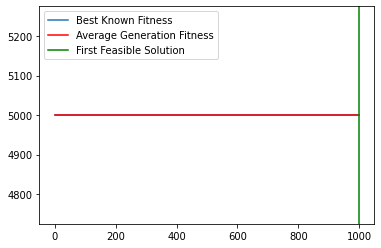

In [5]:
max_generations = 1000
population_size = 10
offspring_amount = 20

optimizer = BaseGA(env)
optimizer.set_minimize()
optimizer.configure('makespan', 'twopointcrossover', 'roulettewheel', 'randomize')
last_time_slot = 5000
# set all delivery dates to last time slot
for order in orders:
    order[1] = last_time_slot
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True, randomize_until_feasible=True)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

Current generation: 0, Current Best: 20000, not feasible
Current generation: 1, Current Best: 20000, not feasible
Current generation: 2, Current Best: 20000, not feasible
Current generation: 3, Current Best: 20000, not feasible
Current generation: 4, Current Best: 20000, not feasible
Current generation: 5, Current Best: 20000, not feasible
Current generation: 6, Current Best: 20000, not feasible
Current generation: 7, Current Best: 20000, not feasible
Current generation: 8, Current Best: 20000, not feasible
Current generation: 9, Current Best: 20000, not feasible
Current generation: 10, Current Best: 20000, not feasible
Current generation: 11, Current Best: 20000, not feasible
Current generation: 12, Current Best: 20000, not feasible
Current generation: 13, Current Best: 20000, not feasible
Current generation: 14, Current Best: 20000, not feasible
Current generation: 15, Current Best: 20000, not feasible
Current generation: 16, Current Best: 20000, not feasible
Current generation: 17, 

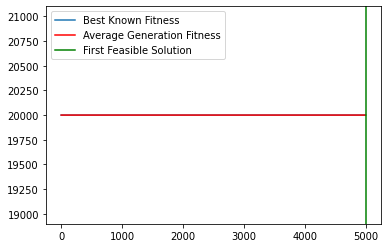

In [6]:
max_generations = 5000
population_size = 10
offspring_amount = 20
earliest_time_slot = 0
last_time_slot = 20000

optimizer = BaseGA(env)
optimizer.set_minimize()
optimizer.configure('makespan', 'twopointcrossover', 'roulettewheel', 'randomize')
# set all delivery dates to last time slot
for order in orders:
    order[1] = last_time_slot
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True, randomize_until_feasible=True, randomize_until_feasible_probability=0.5)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

<h3>Testing pygad</h3>

In [10]:
import pygad

pygad helper functions

In [11]:
def reformat_pygad_result(solution, orders, environment):
    j = 0
    result = []
    for i in range(len(solution)):
        if j == 0:
            result.append([])
        result[len(result)-1].append(solution[i])
        j += 1
        if j > 2:
            j = 0
    workstation_assignments = dict()
    for i in range(len(result)):
        operation = result[i]
        if operation[1] not in workstation_assignments:
            workstation_assignments[operation[1]] = []
        _, order = map_index_to_operation(i, orders, environment)
        workstation_assignments[operation[1]].append([order[2], order[0], i, operation[0], operation[2], environment.get_duration(operation[0], operation[1])])
    return workstation_assignments

In [12]:
from optimizer_components import map_index_to_operation

earliest_time_slot = 0
last_time_slot = 5000

def feasible(solution):
    j = 0
    for i in range(len(solution)):
        if j == 2:
            # just check if task and workstation do exist
            """if env.get_task(solution[i-2]) is None or env.get_workstation(solution[i-1]) is None:
                return False"""
            if solution[i] < earliest_time_slot:
                return False
            duration = env.get_duration(solution[i-2], solution[i-1])
            if duration == 0: # illegal combination
                return False
            if solution[i] + duration > last_time_slot:
                return False
        j += 1
        if j > 2:
            j = 0
    return True # just testing

def fitness_function(solution, solution_idx):
    fitness = 0
    if feasible(solution):
        min = float('inf')
        max = -float('inf')
        i = 0
        for gene in solution:
            if i == 2:
                if gene < min:
                    min = gene
                duration = env.get_duration(solution[i-2], solution[i-1])
                if gene + duration > max:
                    max = gene + duration
            i += 1
            if i > 2:
                i = 0
        fitness += abs(max - min)
    else:
        fitness = 2 * last_time_slot
    return -fitness

def only_valid_mutation_function(offsprings, ga_instance):
    start_low = ga_instance.gene_space[2]['low']
    start_high = ga_instance.gene_space[2]['high']
    
    for offspring in offsprings:
        j = 0
        for i in range(len(offspring)):
            if j == 0:
                valid_workstations = env.get_valid_workstations(offspring[i])
            if random.random() < 1/len(offspring): # just fix mutation probability for now
                if j == 1:
                    offspring[i] = random.choice(valid_workstations).id
                elif j == 2:
                    offspring[i] = random.randint(start_low, start_high)
            j += 1
            if j > 2:
                j = 0
    return offsprings

def mutation_function(offsprings, ga_instance):
    workstation_low = ga_instance.gene_space[1]['low']
    workstation_high = ga_instance.gene_space[1]['high']
    start_low = ga_instance.gene_space[2]['low']
    start_high = ga_instance.gene_space[2]['high']
    
    for offspring in offsprings:
        j = 0
        for i in range(len(offspring)):
            if random.random() < 1/len(offspring): # just fix mutation probability for now
                if j == 1:
                    offspring[i] = random.randint(workstation_low, workstation_high)
                elif j == 2:
                    offspring[i] = random.randint(start_low, start_high)
            j += 1
            if j > 2:
                j = 0
    return offsprings

flat_input = [item for sublist in input for item in sublist]
num_genes = len(flat_input) * 3
num_generations = 1000
num_parents_mating = 25
sol_per_pop = 50
init_range_low = 0
init_range_high = last_time_slot
parent_selection_type = 'rws'
keep_parents = 1
crossover_type = 'single_point'
#mutation_type = 'random'
#mutation_type = mutation_function
mutation_type = only_valid_mutation_function
mutation_percentage_genes = 10
fitness_func = fitness_function
gene_type = int
gene_space = []
space_tasks = {'low': 0, 'high': len(tasks)-1}#[0, len(tasks)-1]
space_workstations = {'low': 1, 'high': len(workstations)-1}#[0, len(workstations)-1]
space_time = {'low': earliest_time_slot, 'high': last_time_slot}#[earliest_time_slot, last_time_slot]
j = 0
for i in range(num_genes):
    if j == 0:
        gene_space.append(space_tasks)
    elif j == 1:
        gene_space.append(space_workstations)
    else:
        gene_space.append(space_time)
    j += 1
    if j > 2:
        j = 0
ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_func, sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high, parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type, mutation_type=mutation_type, mutation_percent_genes=mutation_percentage_genes, gene_type=gene_type, gene_space=gene_space)
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

workstation_assignments = reformat_pygad_result(solution, orders, env)
visualize(workstation_assignments, [], [], [], num_generations+1)

Parameters of the best solution : [   3    2 1126    8    2 4068    6    2 4015    7    2 1508    3    2
 3881    2    1 1067    0    1 1171    5    2 3702    2    1 1325    4
    2 4090    2    1 1120    3    2 2896    7    2 3726    3    2 2934
    5    2 2915    0    1 4177    5    2 4076    2    1  809    1    1
 3999    7    2  630    3    2 3780    4    2 4532    7    2  565    8
    2 2688    6    2 2376    7    2 1649    6    2 4429    7    2 3893
    8    2 4774    3    2 1225    4    2  545    5    2 2476    0    1
 3616    7    2 1006    3    2 3084    4    2  598    5    2 4533    5
    2 2392    7    2 2465    8    2  988    2    1 3727    6    2 3161
    6    2 2920    4    2  815    0    1  639    3    2 1112    5    2
 3507    5    2 3490    1    1 2079    2    1 3567    7    2 4719    2
    1 1092    2    1 2544    7    2 3669    3    2 3940    0    1 3958
    4    2  935    8    2 1839    5    2 1853    6    2 1677]
Fitness value of the best solution = -4294


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
earliest_time_slot = 0
last_time_slot = 5000
operations = []

def get_alternative_tasks(task_id):
    task = env.get_task(task_id)
    tasks = env.tasks
    alternatives = []
    for t in tasks:
        if task.result_resources[0][0] == t.result_resources[0][0] and t not in alternatives and t.id != task_id:
            alternatives.append(t)
    return alternatives

def mutation_function(offsprings, ga_instance):
    for offspring in offsprings:
        for i in range(len(operations)):
            if random.random() < 1 / len(operations):
                task = offspring[i*3]
                alternatives = get_alternative_tasks(task)
                offspring[i*3] = random.choice(alternatives).id
                offspring[i*3+1] = random.choice(env.get_valid_workstations(offspring[i*3])).id
                offspring[i*3+2] = random.randint(earliest_time_slot, last_time_slot)
    return offsprings

def fitness_function(solution, solution_idx):
    fitness = 0
    if feasible(solution):
        min = float('inf')
        max = -float('inf')
        i = 0
        for gene in solution:
            if i == 2:
                if gene < min:
                    min = gene
                duration = env.get_duration(solution[i-2], solution[i-1])
                if gene + duration > max:
                    max = gene + duration
            i += 1
            if i > 2:
                i = 0
        fitness += abs(max - min)
    else:
        fitness = 2 * last_time_slot
    return -fitness

for order in orders_model:
    for resource in order.resources:
        recipe = resource.recipes[0] # just use recipe 0 for now
        recipe_tasks = env.get_all_tasks_for_recipe(recipe.id)
        results = dict()
        for task in recipe_tasks:
            if task.result_resources[0][0] not in results:
                results[task.result_resources[0][0]] = []
            results[task.result_resources[0][0]].append(task)
        for key in results:
            operations.append(random.choice(results[key]).id)
assignments = []
for operation in operations:
    workstation = env.get_valid_workstations(operation)
    assignments.append(operation)
    assignments.append(random.choice(workstation).id)
    assignments.append(random.randint(earliest_time_slot, last_time_slot))

num_genes = len(assignments) * 3
num_generations = 1000
num_parents_mating = 25
sol_per_pop = 50
init_range_low = 0
init_range_high = last_time_slot
parent_selection_type = 'rws'
keep_parents = 1
crossover_type = 'two_points'
mutation_type = mutation_function
mutation_percentage_genes = 10
fitness_func = fitness_function
gene_type = int
ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_func, sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high, parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type, mutation_type=mutation_type, mutation_percent_genes=mutation_percentage_genes, gene_type=gene_type, gene_space=gene_space)
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

workstation_assignments = reformat_pygad_result(solution, orders, env)
visualize(workstation_assignments, [], [], [], num_generations+1)

TypeError: When the parameter 'gene_space' is nested, then its length must be equal to the value passed to the 'num_genes' parameter. Instead, length of gene_space (8) != num_genes (180)

Testing DEAP

In [ ]:
from deap import creator, base, tools, algorithms

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return sum(individual),

#NOTE: not in use yet
def fitness_function(solution):
    fitness = 0
    if feasible(solution):
        min = float('inf')
        max = -float('inf')
        i = 0
        for gene in solution:
            if i == 2:
                if gene < min:
                    min = gene
                duration = env.get_duration(solution[i-2], solution[i-1])
                if gene + duration > max:
                    max = gene + duration
            i += 1
            if i > 2:
                i = 0
        fitness += abs(max - min)
    else:
        fitness = 2 * last_time_slot
    return fitness

#NOTE: not in use yet
def mutation_function(offspring):
    for i in range(len(offspring)):
        if random.random() < 1 / len(operations):
            task = offspring[i*3]
            alternatives = get_alternative_tasks(task)
            offspring[i*3] = random.choice(alternatives).id
            offspring[i*3+1] = random.choice(env.get_valid_workstations(offspring[i*3])).id
            offspring[i*3+2] = random.randint(earliest_time_slot, last_time_slot)
    return offspring

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=300)

NGEN=40
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
top10 = tools.selBest(population, k=10)
print(top10[0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Visualization Code

In [13]:
def get_colors(n): 
    ret = [] 
    r = int(random.random() * 256) 
    g = int(random.random() * 256) 
    b = int(random.random() * 256) 
    step = 256 / n 
    for i in range(n): 
        r += step 
        g += step 
        b += step 
        r = int(r) % 256 
        g = int(g) % 256 
        b = int(b) % 256 
        ret.append((r,g,b))  
    return ret

def visualize(data):
    # data format: 0 - workstation, 1 - job id, 2 - start time, 3 - duration
    colors = {}
    rgb_values = get_colors(len(orders))
    for i in range(len(orders)):
        colors[str(f'Order {i}')] = f'rgb({rgb_values[i][0]}, {rgb_values[i][1]}, {rgb_values[i][2]})' # just ignore colors for now
    composed_data = []
    
    for i in range(len(data)):
        label = f'W{data[i][0]}'
        start = data[i][2]
        end = start + data[i][3]
        composed_data.append(
                    dict(Task=label, Start=start, Finish=end, Resource=f'Order {order_for_index[i]}')
                )
        #print(composed_data)
    fig = ff.create_gantt(composed_data, colors=colors, index_col='Resource', show_colorbar=True,
                        group_tasks=True, showgrid_x=True)
    fig.update_layout(xaxis_type='linear')
    """import plotly.express as px
    fig = px.timeline(composed_data, x_start='Start', x_end='Finish', y='Task', color='Resource')""" # for some reason doesn't do what it's supposed to do
    fig.show()

In [14]:
import pygad
import plotly.figure_factory as ff
"""
# bin packing
dict<task_id, dict<workstation_id, duration>> for lookups

> min duration for each workstation
> balance amount of tasks on each workstations
> balance working time on each workstation

> feasible if all tasks are on a valid workstation for that task

# time slot scheduling
# move starting times for each job on each workstation
> min makespan
> min tardy jobs

> feasible if order of associated jobs is in tact
"""
# duration lookup table
duration_lookup_table = dict()
for task in tasks:
    for workstation in env.get_valid_workstations(task.id):
        if not task in duration_lookup_table:
            duration_lookup_table[task.id] = dict()
        duration_lookup_table[task.id][workstation.id] = env.get_duration(task.id, workstation.id)

operations = []
order_for_index = []
for order in orders_model:
    for resource in order.resources:
        recipe = resource.recipes[0] # just use recipe 0 for now
        recipe_tasks = env.get_all_tasks_for_recipe(recipe.id)
        results = dict()
        for task in recipe_tasks:
            if task.result_resources[0][0] not in results:
                results[task.result_resources[0][0]] = []
            results[task.result_resources[0][0]].append(task)
        for key in results:
            operations.append(random.choice(results[key]).id)
            order_for_index.append(order.id)
assignments = []

for operation in operations:
    workstation = env.get_valid_workstations(operation)
    # random init
    assignments.append(random.choice(workstation).id)

def fitness_function(solution, solution_idx):
    bins = dict()
    sum = 0
    max_sum = 0
    for operation in list(duration_lookup_table.keys()):
        max = -float('inf')
        for workstation in list(duration_lookup_table[operation].keys()):
            if duration_lookup_table[operation][workstation] > max:
                max = duration_lookup_table[operation][workstation]
        max_sum += max
    for i in range(len(solution)):
        if solution[i] not in duration_lookup_table[operations[i]]: # illegal combination
            return len(solution) * 10000 * -1
        if i not in bins:
            bins[i] = 0
        sum += duration_lookup_table[operations[i]][solution[i]] # minimize working minutes for all workstations
        #bins[i] += duration_lookup_table[operations[i]][solution[i]]
    return sum * -1

def mutation_function(offsprings, ga_instance):
    for offspring in offsprings:
        p = 1 / len(offspring)
        for i in range(len(offspring)):
            if random.random() < p:
                offspring[i] = random.choice(list(duration_lookup_table[operations[i]].keys()))
    return offsprings

num_genes = len(assignments)
num_generations = 2500
num_parents_mating = 50
sol_per_pop = 100
init_range_low = 0
init_range_high = last_time_slot
parent_selection_type = 'rws'
keep_parents = 10
crossover_type = 'two_points'
mutation_type = mutation_function
#mutation_type = 'random'
mutation_percentage_genes = 10
fitness_func = fitness_function
gene_type = int
space_workstations = {'low': 1, 'high': len(workstations)-1}
gene_space = []
for i in range(len(assignments)):
    gene_space.append(space_workstations)
ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_func, sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high, parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type, mutation_type=mutation_type, mutation_percent_genes=mutation_percentage_genes, gene_type=gene_type, gene_space=gene_space)
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=abs(solution_fitness) - 1))

def is_feasible(solution):
    for i in range(len(solution)):
        start = solution[i]
        end = start + duration_lookup_table[operations[i]][assignments[i]]
        if end > last_time_slot:
            return False
        if start < earliest_time_slot:
            return False
        # overlap
        same_workstation = [] # append indices of jobs running on the same workstation
        for j in range(len(assignments)):
            if assignments[j] == assignments[i] and i != j:
                same_workstation.append(j)
        for j in range(len(same_workstation)):
            other_start = solution[same_workstation[j]]
            other_end = other_start + duration_lookup_table[operations[same_workstation[j]]][assignments[same_workstation[j]]]
            if start > other_start and start < other_end:
                return False
            if end > other_start and end < other_end:
                return False
            if other_start > start and other_start < end:
                return False
            if other_end > start and other_end < end:
                return False
        # check sequence
        order = order_for_index[i]
        if i > 0:
            if order_for_index[i-1] == order: # same order
                prev_start = solution[i-1]
                prev_end = prev_start + duration_lookup_table[operations[i-1]][assignments[i-1]]
                if prev_end > start:
                    return False
    return True

def fitness_function_time_slots(solution, solution_idx):
    fitness = 1
    if not is_feasible(solution):
        #fitness += last_time_slot
        return -2 * last_time_slot
    max = -float('inf')
    min = float('inf')
    for i in range(len(solution)):
        start = solution[i]
        end = start + duration_lookup_table[operations[i]][assignments[i]]
        if start < min:
            min = start
        if end > max:
            max = end
    fitness += abs(max - min)
    return -fitness

def mutation_function_time_slots(offsprings, ga_instance):
    for offspring in offsprings:
        p = 1 / len(offspring)
        for i in range(len(offspring)):
            if random.random() < p:
                offspring[i] = random.randint(earliest_time_slot, last_time_slot)
    return offsprings

assignments = solution
start_slots = []
for assignment in assignments:
    start_slots.append(0)
num_genes = len(start_slots)
num_generations = 2500
num_parents_mating = 50
sol_per_pop = 100
init_range_low = 0
init_range_high = last_time_slot
parent_selection_type = 'rws'
keep_parents = 10
crossover_type = 'two_points'
mutation_type = mutation_function_time_slots
#mutation_type = 'random'
mutation_percentage_genes = 10
fitness_func = fitness_function_time_slots
gene_type = int
space_time = {'low': earliest_time_slot, 'high': last_time_slot}
gene_space = []
for i in range(len(assignments)):
    gene_space.append(space_time)
ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_func, sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high, parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type, mutation_type=mutation_type, mutation_percent_genes=mutation_percentage_genes, gene_type=gene_type, gene_space=gene_space)
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=abs(solution_fitness) - 1))


Parameters of the best solution : [1 2 1 2 2 2 2 2 1 1 1 2 2 2 2 2 1 2 1 2]
Fitness value of the best solution = 908
Parameters of the best solution : [3433 3664 1700 1956 1689 2986 1560 2110 2475 3720 2968 3739 2901 3417
 2488 3037 1814 3179 2151 3287]
Fitness value of the best solution = 2244


In [15]:
data = []
for i in range(len(solution)):
    data.append([assignments[i], operations[i], solution[i], duration_lookup_table[operations[i]][assignments[i]]])
visualize(data)

OneNote Example

In [55]:
# tasks = [0, 1, 2]
jobs = [        # row = task_id
    [0, 1, 2],
    [0, 1, 2],
    [0, 1]
]
# assume orders: {0, 1, 2}
jobs_to_schedule = [0, 1, 2, 0, 1, 2, 0, 1]
order_for_index = [0, 0, 0, 1, 1, 1, 2, 2]
assignments = [0, 1, 2, 0, 2, 1, 1, 2]
durations = [3, 2, 4, 2, 1, 3, 2, 4]
# start_times = ?
input = [0 for _ in range(len(jobs_to_schedule))]
max_time = 0
for duration in durations:
    max_time += duration
print(f'Max duration: {max_time}')
max_time = max_time# * 3 # leave some room 
def mutation_function(offsprings, ga_isntance):
    for offspring in offsprings:
        p = 1 / len(offspring)
        for i in range(len(offspring)):
            if random.random() < p:
                offspring[i] = random.randint(0, max_time)
    return offsprings

def is_feasible(solution):
    for i in range(len(solution)):
        if solution[i] < 0:
            return False
        if solution[i] + durations[i] > max_time:
            return False
        same_workstation = []
        workstation = assignments[i]
        for j in range(len(assignments)):
            if i != j and assignments[j] == workstation:
                same_workstation.append(j)
        start = solution[i]
        end = solution[i] + durations[i]
        # check overlap on same workstation
        for j in range(len(same_workstation)):
            other_start = solution[same_workstation[j]]
            other_end = other_start + durations[same_workstation[j]]
            if start >= other_start and start < other_end:
                return False
            if end > other_start and end <= other_end:
                return False
            if other_start >= start and other_start < end:
                return False
            if other_end > start and other_end <= end:
                return False
        order = order_for_index[i]
        # check sequence
        if i > 0:
            j = 1
            while i-j >= 0 and order_for_index[i-j] == order:
                prev_start = solution[i-j]
                prev_end = prev_start + durations[i-j]
                if prev_end > start:
                    return False
                j += 1
    return True

def fitness_function(solution, solution_idx):
    fitness = 1
    if not is_feasible(solution):
        # fitness += max_time
        return -2 * max_time
    min = float('inf')
    max = -float('inf')
    for i in range(len(solution)):
        if solution[i] < min:
            min = solution[i]
        if solution[i] + durations[i] > max:
            max = solution[i] + durations[i]
    fitness += abs(max - min)
    return -fitness

def idle_time_fitness_function(solution, solution_idx):
    fitness = 1
    if not is_feasible(solution):
        return -10 * max_time
    workstations = dict()
    for i in range(len(assignments)):
        if assignments[i] not in workstations:
            workstations[assignments[i]] = []
        workstations[assignments[i]].append(i) # add all indices which are assigned to each workstation
    for workstation in workstations: # sort by start points
        ordered = sorted(workstations[workstation], key=lambda x: solution[x]) # should create a copy
        for i in range(len(ordered)):
            if i == 0:
                fitness += solution[ordered[i]] # add distance to 0 for first job scheduled on workstation
            else:
                fitness += (solution[ordered[i]] - (solution[ordered[i-1]] + durations[ordered[i-1]])) # start - end_prev
    return -(fitness)

num_genes = len(input)
num_generations = 2500
num_parents_mating = 50
sol_per_pop = 100
init_range_low = 0
init_range_high = max_time
parent_selection_type = 'rws'
keep_parents = 10
crossover_type = 'two_points'
mutation_type = mutation_function
#mutation_type = 'random'
mutation_percentage_genes = 10
mutation_num_genes = 1
fitness_func = fitness_function
#fitness_func = idle_time_fitness_function
gene_type = int
space_time = {'low': 0, 'high': max_time}
gene_space = []
for i in range(len(jobs_to_schedule)):
    gene_space.append(space_time)
ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_func, sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high, parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type, mutation_type=mutation_type, mutation_num_genes=mutation_num_genes, mutation_percent_genes=mutation_percentage_genes, gene_type=gene_type, gene_space=gene_space)#, save_solutions=True)
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=abs(solution_fitness) - 1))


Max duration: 21
Parameters of the best solution : [ 7 12 14 11 13 15  7  9]
Fitness value of the best solution = 11


In [56]:
data = []
for i in range(len(jobs_to_schedule)):
    data.append([assignments[i], jobs_to_schedule[i], solution[i], durations[i]])
visualize(data)

In [57]:
print(f'Idle Time: {abs(idle_time_fitness_function(solution, 0)) -1}')
print(f'Makespan: {abs(fitness_function(solution, 0)) - 1}')

Idle Time: 28
Makespan: 11
